# Install and Import Libraries

In [ ]:
!pip install opencv-python
!pip install pafy
!pip install youtube-dl moviepy pydot
!pip install tensorflow
!pip install matplotlib
!pip install scikit-learn

In [10]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

# Control Randomness

In [11]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# Dataset

- We will be using the UCF50 - Action Recognition Dataset, consisting of realistic videos taken from youtube which differentiates this data set from most of the other available action recognition data sets as they are not realistic and are staged by actors
- It has 50 Action Categories
- 199 Average Number of Frames per Video
- Link: https://www.crcv.ucf.edu/data/UCF50.php

# Visualize the dataset

- For visualization, we will pick 20 random categories from the dataset and a random video from each selected category and will visualize the first frame of the selected videos with their associated labels written

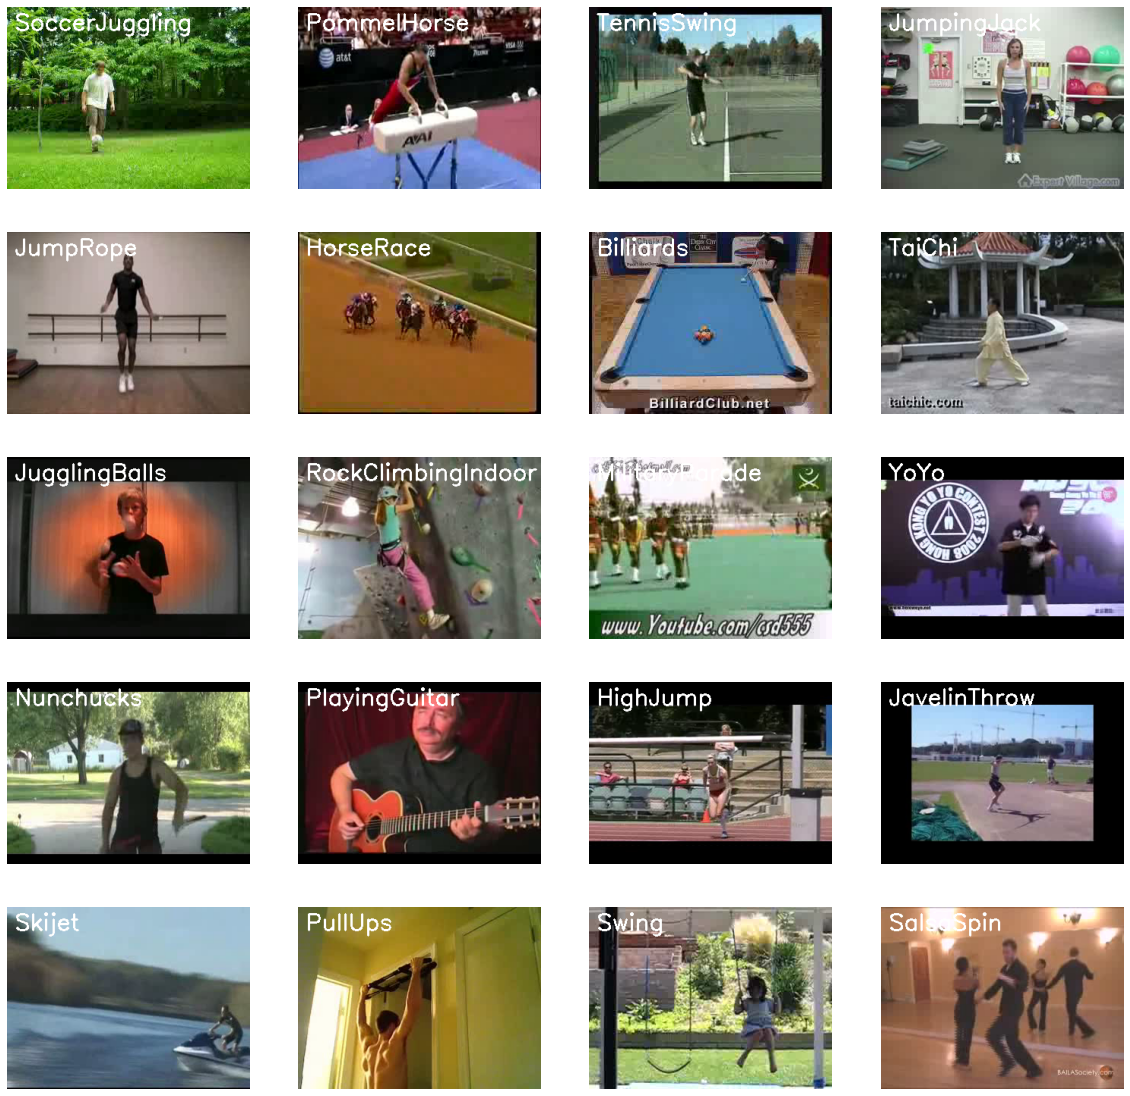

In [12]:
plt.figure(figsize = (20, 20))

all_classes_names = os.listdir('dataset/UCF50')

# Generate a list of 20 random values
random_range = random.sample(range(len(all_classes_names)), 20)

for counter, random_index in enumerate(random_range, 1):
    selected_class_Name = all_classes_names[random_index]

    video_files_names_list = os.listdir(f'dataset/UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(f'dataset/UCF50/{selected_class_Name}/{selected_video_file_name}')
    _, bgr_frame = video_reader.read()
    video_reader.release()
 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

# Data Preprocessing

In [13]:
# Constants

IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

SEQUENCE_LENGTH = 20

DATASET_DIR = "dataset/UCF50"

CLASSES_LIST = ["PullUps", "PlayingGuitar", "Biking", "Punch"]

- Function to Extract, Resize & Normalize Frames

In [14]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        
        success, frame = video_reader.read() 
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255

        frames_list.append(normalized_frame)
     
    video_reader.release()

    return frames_list

- Function for Dataset Creation

In [15]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []
    
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        print(f'Extracting Data of Class: {class_name}')
        
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels, video_files_paths

- Create the dataset.

In [16]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: PullUps
Extracting Data of Class: PlayingGuitar
Extracting Data of Class: Biking
Extracting Data of Class: Punch


- Convert labels into one-hot-encoded vectors

In [17]:
one_hot_encoded_labels = to_categorical(labels)

# Split the Data into Train and Test Set

In [18]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

# Model Building

We will implement LRCN known as the Long-term Recurrent Convolutional Network, which combines CNN and LSTM layers in a single model. The Convolutional layers are used for spatial feature extraction from the frames, and the extracted spatial features are fed to LSTM layer(s) at each time-steps for temporal sequence modeling. This way the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.

In [19]:
def create_LRCN_model():
    model = Sequential()
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    model.summary()

    return model

In [20]:
LRCN_model = create_LRCN_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 20, 64, 64, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 20, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 20, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 20, 16, 16, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 20, 4, 4, 32)    

# Train the Model

In [23]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

LRCN_trained_model = LRCN_model.fit(x = features_train, y = labels_train, epochs = 80, batch_size = 5 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/80
70/70 [==============================] - 9s 92ms/step - loss: 1.3659 - accuracy: 0.3229 - val_loss: 1.2686 - val_accuracy: 0.4773
Epoch 2/80
70/70 [==============================] - 7s 103ms/step - loss: 1.1114 - accuracy: 0.4629 - val_loss: 1.0982 - val_accuracy: 0.4432
Epoch 3/80
70/70 [==============================] - 9s 122ms/step - loss: 0.8847 - accuracy: 0.6257 - val_loss: 0.9226 - val_accuracy: 0.6023
Epoch 4/80
70/70 [==============================] - 9s 127ms/step - loss: 0.8939 - accuracy: 0.6314 - val_loss: 0.8066 - val_accuracy: 0.7159
Epoch 5/80
70/70 [==============================] - 9s 128ms/step - loss: 0.7748 - accuracy: 0.6857 - val_loss: 0.7261 - val_accuracy: 0.7500
Epoch 6/80
70/70 [==============================] - 9s 123ms/step - loss: 0.5976 - accuracy: 0.7743 - val_loss: 0.5954 - val_accuracy: 0.8068
Epoch 7/80
70/70 [==============================] - 9s 126ms/step - loss: 0.5367 - accuracy: 0.7971 - val_loss: 0.6222 - val_accuracy: 0.7614
Epoch 8

# Evaluation

In [24]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

5/5 [==============================] - 1s 252ms/step - loss: 0.2370 - accuracy: 0.9252


# Save the Model

In [25]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

LRCN_model.save(model_file_name)

# Test on YouTube videos

In [31]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):

    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    predicted_class_name = ''

    while video_reader.isOpened():

        ok, frame = video_reader.read() 
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)
        
        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            predicted_label = np.argmax(predicted_labels_probabilities)

            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

In [48]:
video_title='guitar'
input_video_file_path= f'{test_videos_directory}/{video_title}.mp4'

In [49]:
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
